Use QuTiP Python Package to simulate two-level quantum system dynamics.

1. Set up Hamiltonian for two-level dynamics in the rotating frame and rotating wave approximation.
2. Execute Rabi oscillations and Rabi spectroscopy.
3. Execute Ramsey oscillations (in detuning and wait time) and Ramsey spectroscopy.
4. Create animations for Rabi and Ramsey sequences on the Bloch sphere.

In [187]:
#import relevant packages
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import imageio
import os
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import ArtistAnimation

In [188]:
#two-level system dynamics. Assume quantization axis is along z-axis.
ket_g = basis(2,0) #|up> = |g> in a two-level system
ket_e = basis(2,1) #|down> = |e> in a two-level system

#assume work in rotating frame. Define Hamiltonian.

#\Omega is rabi frequency. \Omega' = sqrt(\Omega^2 + \delta^2) is the effective rabi frequency.
delta = 0.0 #detuning in units of rabi frequency
rabi = 1.0 #rabi frequency
phi = 0.0*np.pi #phase of rabi frequency

H = delta*sigmaz()/2 + rabi*sigmax()*np.cos(phi)/2 + rabi*sigmay()*np.sin(phi)/2
ket_init = ket_g

#evolve system in time using mesolve (master equation solver, basically a time-dependent Schrodinger equation solver for open quantum systems) 
#the basic syntax is mesolve(H, ket_init, t, c_ops=[], e_ops=[]). 
#here c_ops is irrelevant since we assume pure state. e_ops is the list of operator(s) whose expectation value we want to calculate.

#execute a Rabi oscillation sequence
t = np.linspace(0, 2.0*np.pi, 100)
result1 = mesolve(H, ket_g, t, c_ops=[], e_ops=[])

/var/folders/31/m4kzls1x2ms3ys1t245y77j80000gn/T/ipykernel_92276/1778323000.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, azim=-40, elev=30)


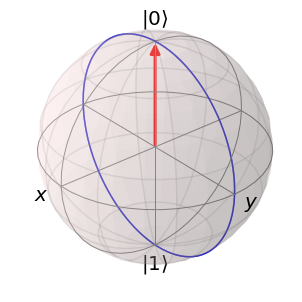

In [189]:
#for the Rabi cycle above, plot evolution of Bloch state vector on Bloch sphere and save as mp4 animation
fig = plt.figure()
ax = Axes3D(fig, azim=-40, elev=30)
b = Bloch(axes=ax)

# make points a list of unknown cols and 3 rows
points = [[] for _ in range(3)]

def animate(i):
    b.clear()
    state = result1.states[i]
    b.add_states(state)
    
    # Add the point to the list
    points[0].append(expect(sigmax(), state))
    points[1].append(expect(sigmay(), state))
    points[2].append(expect(sigmaz(), state))
    
    # Add the points to the Bloch sphere
    b.add_points(points, meth='l')
    b.make_sphere()
    return ax

def init():
    b.vector_color = ['r']
    return ax


ani = animation.FuncAnimation(fig, animate, np.arange(len(result1.states)),
                              init_func=init, blit=False, repeat=False)
ani.save('rabi_cycle.mp4', fps=10, writer='ffmpeg')

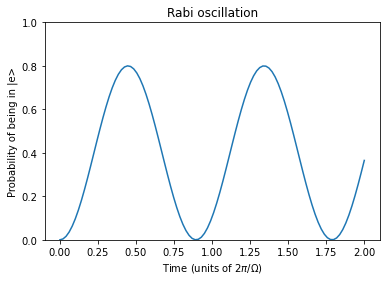

In [190]:
#For the same Rabi cycle, plot probability of being in |e> as function of time
delta = 0.5 #detuning in units of rabi frequency
rabi = 1.0 #rabi frequency
phi = 0.0*np.pi #phase of rabi frequency

H = delta*sigmaz()/2 + rabi*sigmax()*np.cos(phi)/2 + rabi*sigmay()*np.sin(phi)/2
ket_init = ket_g

t = np.linspace(0, 4.0*np.pi, 100)
result2 = mesolve(H, ket_g, t, c_ops=[], e_ops=[sigmaz()])

p_e = 1/2*(1 - result2.expect[0])
plt.plot(t/(2*np.pi), p_e)
plt.xlabel('Time (units of 2$\pi$/$\Omega$)')
plt.ylabel('Probability of being in |e>')
plt.title('Rabi oscillation')
plt.ylim([0,1])
plt.show()


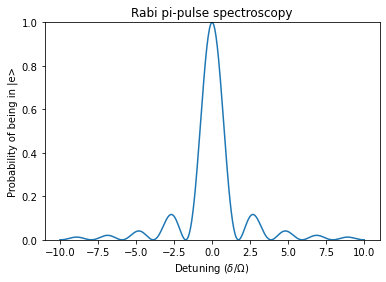

In [191]:
#For a Rabi pi-pulse, plot probability of being in |e> as function of detuning
delta = np.linspace(-10.0, 10.0, 500)
rabi = 1.0 #rabi frequency
phi = 0.0*np.pi #phase of rabi frequency
ket_init = ket_g

p_e = []
#pi pulse time is pi/rabi freq
t_pi = np.pi/rabi
t = np.linspace(0, t_pi, 100)
for d in delta:
    H = d*sigmaz()/2 + rabi*sigmax()*np.cos(phi)/2 + rabi*sigmay()*np.sin(phi)/2
    result = mesolve(H, ket_init, t, c_ops=[], e_ops=[sigmaz()])
    p_e.append(1/2*(1 - result.expect[0][-1]))

plt.plot(delta, p_e)
plt.xlabel('Detuning ($\delta$/$\Omega$)')
plt.ylabel('Probability of being in |e>')
plt.title('Rabi pi-pulse spectroscopy')
plt.ylim([0,1])
plt.show()


In [192]:
#execute a Ramsey sequence on the Bloch sphere
delta = 0.2 #detuning in units of rabi frequency
rabi = 1.0 #rabi frequency
phi = 0.0*np.pi #phase of rabi frequency
ket_init = ket_g

#first pi/2 pulse
H = delta*sigmaz()/2 + rabi*sigmax()*np.cos(phi)/2 + rabi*sigmay()*np.sin(phi)/2
#pulse = (np.pi/2)*(1/np.sqrt(rabi**2 + delta**2))
pulse = np.pi/(2*rabi)
t = np.linspace(0, pulse, 100)
result3 = mesolve(H, ket_g, t, c_ops=[], e_ops=[])
ket_intermediate = result3.states[-1]

#free evolution
H = delta*sigmaz()/2
free = 80*pulse
T = np.linspace(0, free, 100)
result4 = mesolve(H, ket_intermediate, T, c_ops=[], e_ops=[])
ket_intermediate2 = result4.states[-1]

#second pi/2 pulse
H = delta*sigmaz()/2 + rabi*sigmax()*np.cos(phi)/2 + rabi*sigmay()*np.sin(phi)/2
t = np.linspace(0, pulse, 100)
result5 = mesolve(H, ket_intermediate2, t, c_ops=[], e_ops=[])
ket_final = result5.states[-1]

/var/folders/31/m4kzls1x2ms3ys1t245y77j80000gn/T/ipykernel_92276/1645415802.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, azim=-40, elev=30)


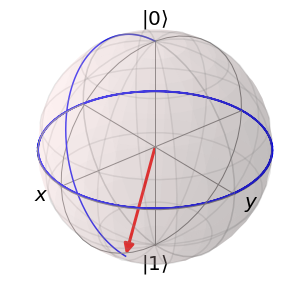

In [193]:
#for the Ramsey sequence above, plot evolution of Bloch state vector on Bloch sphere and save as mp4 animation
fig = plt.figure()
ax = Axes3D(fig, azim=-40, elev=30)
b = Bloch(axes=ax)

# make points a list of unknown cols and 3 rows
points = [[] for _ in range(3)]
def animate(i):
    if i < len(result3.states):
        state = result3.states[i]
    elif i < len(result3.states) + len(result4.states):
        state = result4.states[i - len(result3.states)]
    else:
        state = result5.states[i - len(result3.states) - len(result4.states)]
    
    b.clear()
    b.add_states(state)

    # Add the point to the list
    points[0].append(expect(sigmax(), state))
    points[1].append(expect(sigmay(), state))
    points[2].append(expect(sigmaz(), state))

    # Add the points to the Bloch sphere
    b.add_points(points, meth='l')
    b.make_sphere()

    return ax

def init():
    b.vector_color = ['r']
    return ax

ani = animation.FuncAnimation(fig, animate, np.arange(len(result3.states) + len(result4.states) + len(result5.states)), init_func=init, blit=False, repeat=False)
ani.save('ramsey_sequence.mp4', fps=50, writer='ffmpeg')

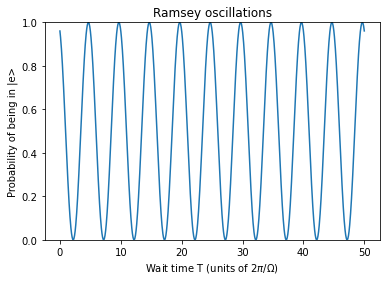

In [194]:
#Ramsey spectroscopy as function of wait time T

#fix parameters
delta = 0.2 #detuning in units of rabi frequency
rabi = 1.0 #rabi frequency
phi = 0.0*np.pi #phase of rabi frequency
ket_init = ket_g

#first pi/2 pulse
H = delta*sigmaz()/2 + rabi*sigmax()*np.cos(phi)/2 + rabi*sigmay()*np.sin(phi)/2
#pulse = (np.pi/2)*(1/np.sqrt(rabi**2 + delta**2))
pulse = np.pi/(2*rabi)
t = np.linspace(0, pulse, 100)
result3 = mesolve(H, ket_g, t, c_ops=[], e_ops=[])
ket_intermediate = result3.states[-1]

#free evolution for varying T
free = np.linspace(0.01, 200*pulse, 1000)

p_e = []
for f in free:
    H = delta*sigmaz()/2
    T = np.linspace(0, f, 100)
    result4 = mesolve(H, ket_intermediate, T, c_ops=[], e_ops=[])
    ket_intermediate2 = result4.states[-1]

    #second pi/2 pulse
    H = delta*sigmaz()/2 + rabi*sigmax()*np.cos(phi)/2 + rabi*sigmay()*np.sin(phi)/2
    t = np.linspace(0, pulse, 100)
    result5 = mesolve(H, ket_intermediate2, t, c_ops=[], e_ops=[sigmaz()])
    
    #calculate probability of being in |e> at end of sequence
    p_e.append(1/2*(1 - result5.expect[0][-1]))


plt.plot(free/(2*np.pi/rabi), p_e)
plt.xlabel('Wait time T (units of 2$\pi$/$\Omega$)')
plt.ylabel('Probability of being in |e>')
plt.title('Ramsey oscillations')
plt.ylim([0,1])
plt.show()

For Ramsey oscillations, we expect the fringe oscillation frequency as a function of T to increase as the detuning \Delta is increased. We also expect the fringe oscillation frequency as a function of detuning \Delta to increase as the wait time T is increased.

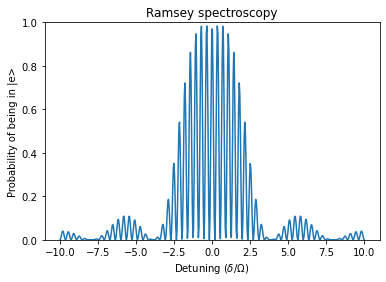

In [195]:
#Ramsey spectroscopy as function of detuning

#fix parameters
delta = np.linspace(-10.0, 10.0, 500)
rabi = 1.0 #rabi frequency
phi = 0.0*np.pi #phase of rabi frequency
ket_init = ket_g

p_e = []
for d in delta:
    #first pi/2 pulse
    H = d*sigmaz()/2 + rabi*sigmax()*np.cos(phi)/2 + rabi*sigmay()*np.sin(phi)/2
    #pulse = np.pi/2/np.sqrt(rabi**2 + d**2)
    pulse = np.pi/(2*rabi)
    t = np.linspace(0, pulse, 100)
    result3 = mesolve(H, ket_g, t, c_ops=[], e_ops=[])
    ket_intermediate = result3.states[-1]

    #free evolution
    free = 10*pulse
    T = np.linspace(0, free, 100)
    H = d*sigmaz()/2
    result4 = mesolve(H, ket_intermediate, T, c_ops=[], e_ops=[])
    ket_intermediate2 = result4.states[-1]

    #second pi/2 pulse
    H = d*sigmaz()/2 + rabi*sigmax()*np.cos(phi)/2 + rabi*sigmay()*np.sin(phi)/2
    t = np.linspace(0, pulse, 100)
    result5 = mesolve(H, ket_intermediate2, t, c_ops=[], e_ops=[sigmaz()])
    
    #calculate probability of being in |e> at end of sequence
    p_e.append(1/2*(1 - result5.expect[0][-1]))

plt.plot(delta, p_e)
plt.xlabel('Detuning ($\delta$/$\Omega$)')
plt.ylabel('Probability of being in |e>')
plt.title('Ramsey spectroscopy')
plt.ylim([0,1])
plt.show()
